# Insurance Cross Sell Learn to Rank Project

On this notebook, most part of the solution proposed (expect for the deployment) for this Learn to Rank Cross Sell project is proposed. You'll find here, all the processing steps of the data used, creation and validation of hyphotesis, and of course, all the steps related to the development of the Machine Learning Model, which is located at the core of the solution.

Enjoy!

## 1. Initialization

### 1.1 Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pickle
import random
import scikitplot as skplt
import xgboost as xgb
import warnings

from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### 1.2 Support Functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [3]:
def precision_at_k(ordered_data,k):

    ordered_data['precision_at_k'] = ordered_data['response'].cumsum() / ordered_data['ranking']

    return ordered_data.loc[k, 'precision_at_k']

In [4]:
def recall_at_k(ordered_data,k):

    ordered_data['recall_at_k'] = ordered_data['response'].cumsum() /  ordered_data['response'].sum()

    return ordered_data.loc[k, 'recall_at_k']

In [5]:
def generate_ordered_df(y_true,y_hat):
    ordered_df = pd.DataFrame({'response':y_true,'score':y_hat[:,1]})
    ordered_df = ordered_df.sort_values('score',ascending=False)
    ordered_df = ordered_df.reset_index(drop = True)
    ordered_df['ranking'] = ordered_df.index + 1
    return ordered_df

In [6]:
def balance_data(X,y):
    over = SMOTE(sampling_strategy='auto')
    under = RandomUnderSampler(sampling_strategy='auto')
    snn = SMOTEENN(sampling_strategy='auto')

    X_balanced, y_balanced = snn.fit_resample(X,y)

    return X_balanced, y_balanced

In [7]:
def calculate_performance(y_true,y_hat,k):
     ordered_df = generate_ordered_df(y_true,y_hat)
     precision = precision_at_k(ordered_df,k=k)
     recall = recall_at_k(ordered_df,k=k)

     return precision, recall

In [8]:
def generate_results_df(model_name,precision_list,recall_list):
    results = pd.DataFrame({
        'Model' : model_name,
        'Precision at K (CV)' : np.round(np.mean(precision_list),3).astype(str),
        'Recall at K (CV)' : np.round(np.mean(recall_list),3).astype(str) 
    },index=[0])

    return results

In [9]:
def cross_validation(model, model_name, folds, k, X, y):

    precision_list = []
    recall_list = []
    skf = StratifiedKFold(n_splits=folds,shuffle=True)

    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        X_train, y_train = balance_data(X_train, y_train)

        if model_name == 'XGBoost':
            model.fit(X_train,y_train,eval_metric='auc')
        else:
            model.fit(X_train,y_train)    
        
        y_hat = model.predict_proba(X_val)

        precision,recall = calculate_performance(y_val, y_hat,k)

        precision_list.append(precision)
        recall_list.append(recall)

    cv_results = generate_results_df(model_name,precision_list,recall_list)
    return cv_results

## 2. Data Reading

On this section, the data used throughout this notebook is imported.

In [10]:
data = pd.read_csv('../Data/train.csv')

In [11]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3. Data Description

On this section, an initial description and pre-processing of data is proposed.

### 3.1 Rename Columns

For the sake of standardization, all column will jave their name converted to a Snake Case format.

In [12]:
lower = lambda x: x.lower()
data.columns = list(map(lower,data.columns))

### 3.2 Data Dimesionality

Let's get an initial grasp of the dimensions of data.

In [13]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 381109
Number of Columns: 12


### 3.3 NaN's

Let's check the presence of NaN's on the dataset.

In [14]:
data.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

There's no presence of NaN values on the dataset, which is a good sign.

### 3.4 Data Types

To a better analysis of data in future steps, some columns have their data types changed.

In [15]:
data['region_code'] = data['region_code'].astype('int64')
data['policy_sales_channel'] = data['policy_sales_channel'].astype('int64')

The "id" column behaves closely to the dataframe index, despite for the fact that starts on 1, not zero. So, let's make the index equals the "id" column, and then dropping the column out.

In [16]:
data = data.drop('id',axis=1)
data.index = data.index + 1

A final check on the data types is made on the last cell.

In [17]:
data.dtypes

gender                   object
age                       int64
driving_license           int64
region_code               int64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object

### 3.5 Statistical Description

To end this section, some simple statistical analysis are proposed on data. For this, numerical and categorical features will be treated separately.

In [18]:
numerical_features = ['age','annual_premium','vintage']
categorical_features = ['gender','driving_license','region_code','previously_insured','vehicle_age','policy_sales_channel','response']

For the Numerical Features some aggregated statistics are calculated for each column.

In [19]:
data[numerical_features].describe()

,age,annual_premium,vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


For the categorical features, charts of the distribution of some columns can be a great idea to obtain a first glance of the data. For this initial analysis, let's check the distributions of "Driving License","Previously Insured" and "Vehicle Age".

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

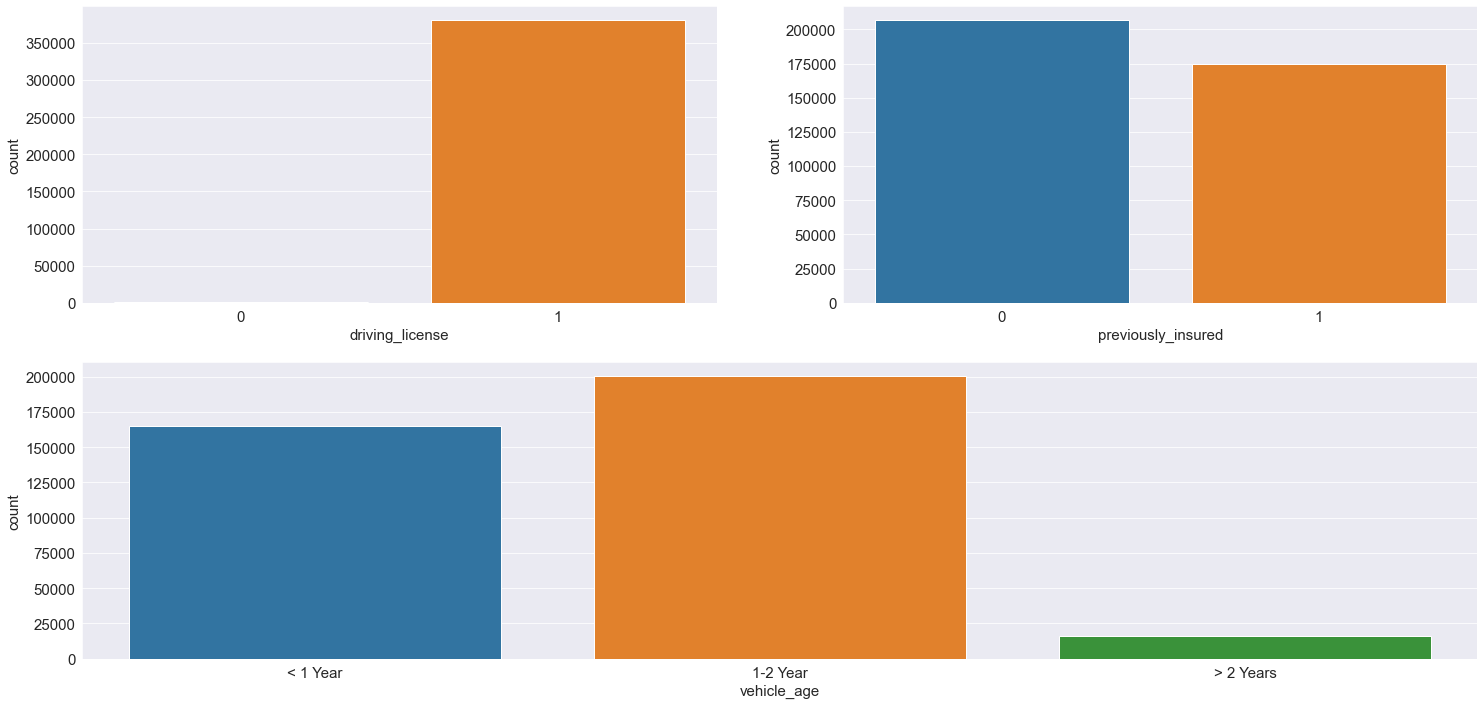

In [20]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(x='driving_license',data=data)

plt.subplot(grid[0,1])
sns.countplot(x='previously_insured',data=data)

plt.subplot(grid[1,:])
sns.countplot(data['vehicle_age'],order=['< 1 Year','1-2 Year','> 2 Years'])

The "Driving License" plot, on the upper left shows that almost all the customers on the dataset have a driving license, which is a very desired behaviour for this problem. On the upper right, "Previously Insured" presents a balanced distribution. On the lower part, the "Vehicle Age" shows that actually most of the cars of the customers are new cars, which seems to also be a desired feature for a vehicle insurance customer.

## 4. Feature Engineering

On this section, some new features are created based on the original ones, with the objective of increasing the model learning and performance. Since the original data has not many columns, however, only two features have been derived on this work.

The first one indicate customers that have vehicle damage, but don't have a driving license, which could be a strong indicator of a illegal driver. And the second feature consider the customers that have experienced a vehicle damage but were not previously insured.

In [21]:
rule = lambda x: 1 if (x['driving_license'] == 0) & (x['vehicle_damage'] == 'Yes') else 0 
data['illegal_driver'] = data.apply(rule,axis=1)

In [22]:
rule = lambda x: 1 if (x['vehicle_damage'] == 'Yes') & (x['previously_insured'] == 0) else 0 
data['no_insured_damage'] = data.apply(rule,axis=1)

## 5. Hyphotesis Creation

To start the Hyphotesis Creation, a Mind Map containing some ideas of the main factors that influence the Target Variable. 

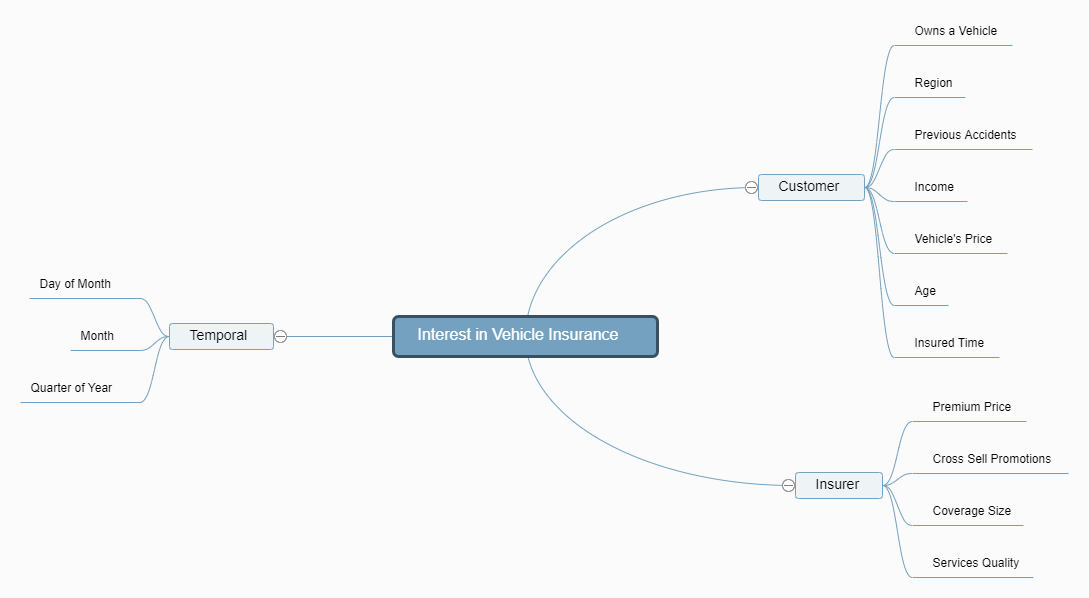

In [23]:
Image(filename='hyphotesis_map.png')

 The main factor on this map is the Customer, since it is from him that the Interest in the offered service is originated. The other two factors, actions by the Insurer and Temporal Features (which can be strongly related to vehicle sales behaviour) can increase the interest on the customers, but not create it. 

 Unfortunately, not all these factors can be studied in detail with the available data, so only hyphotesis contained in the dataset will be developed on the next steps.

  <h2> Hyphotesis List </h2>

  * Hyphotesis 1: Customers that own a vehicle should be interest in the Vehicle Insurance offer.
  * Hyphotesis 2: Customers that had their vehicles damaged in the past should be interest in the Vehicle Insurance offer.
  * Hyphotesis 3: Customers with newer vehicles should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 4: Older customers of the Health Insurance should be more interested in the Vehicle Insurance offer.
  * Hyphotesis 5: Interest in Vehicle Insurance vary between different Regions.
  * Hyphotesis 6: Customers with cheaper Premium prices should be more interest in the Vehicle Insurance offer.

## 6. Exploratory Data Analysis (EDA)

On this section, a more detailed analysis of the data is carried out, starting with Univariate analysis, followed by bivariate analysis, where the hyphotesis created before are tested, and ending with a Multivariate Analysis, both of the Numerical and Categorical variables.

### 6.1 Univariate Analysis

#### 6.1.1 Response Variable

We start the Univariate Analysis subsection with the Response Variable, which involves the interest of customers in the vehicle insurance offer.

<AxesSubplot:xlabel='response', ylabel='count'>

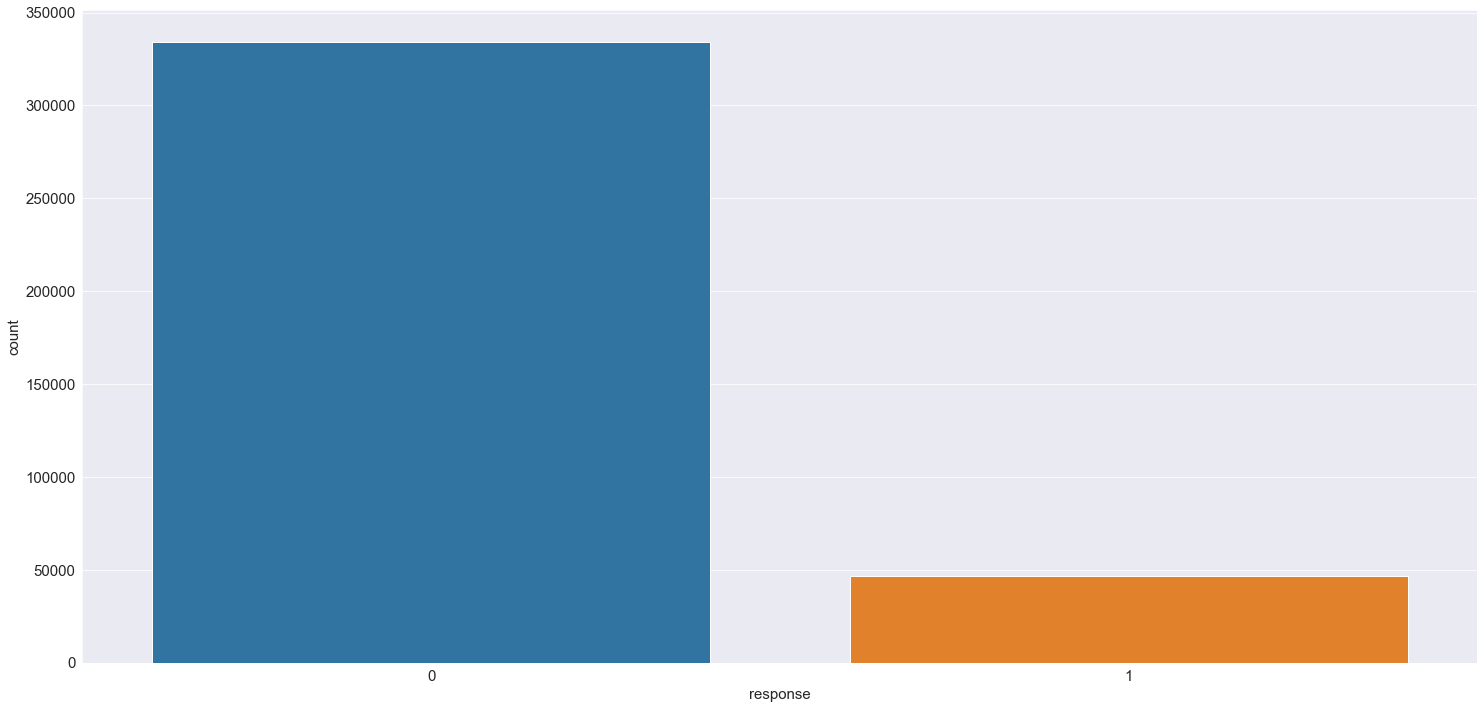

In [24]:
sns.countplot(x='response',data=data)

It is clear that the response is highly unbalanced, which can cause some problems on the model predictions in future steps. A balancing procedure may be needed in future developments of the model. 

#### 6.1.2 Numerical Variables

Despite the fact that most of the columns of the dataset are represented as numbers, only a few of them really represent numerical variables. Let's check those.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_premium'}>],
       [<AxesSubplot:title={'center':'vintage'}>, <AxesSubplot:>]],
      dtype=object)

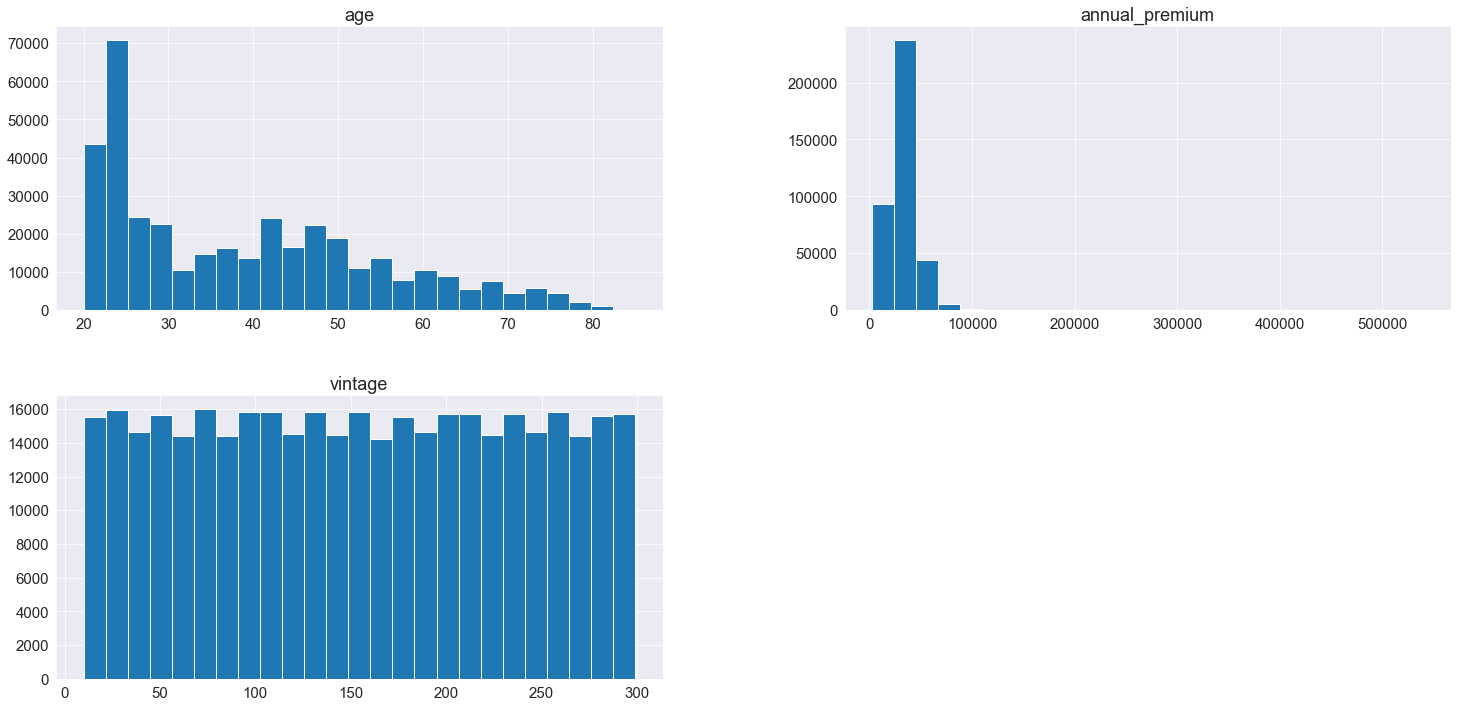

In [25]:
num_features = ['age','annual_premium','vintage']
data[num_features].hist(bins=25)

The "age" columns seems to present a skewed distribution towards younger people, but not something extreme. 

The "annual premium" columns, however, presents a long-tailed distribution, indicating the presence of outliers.

And finally, the "vintage" column presents a almost constant distribution over the range of values, which may result in the fact that the model will not get much useful information of that.

#### 6.1.3 Categorical Variables

For the categorical variables, only some of the columns, that are most relevant, were selected. Let's check those.

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

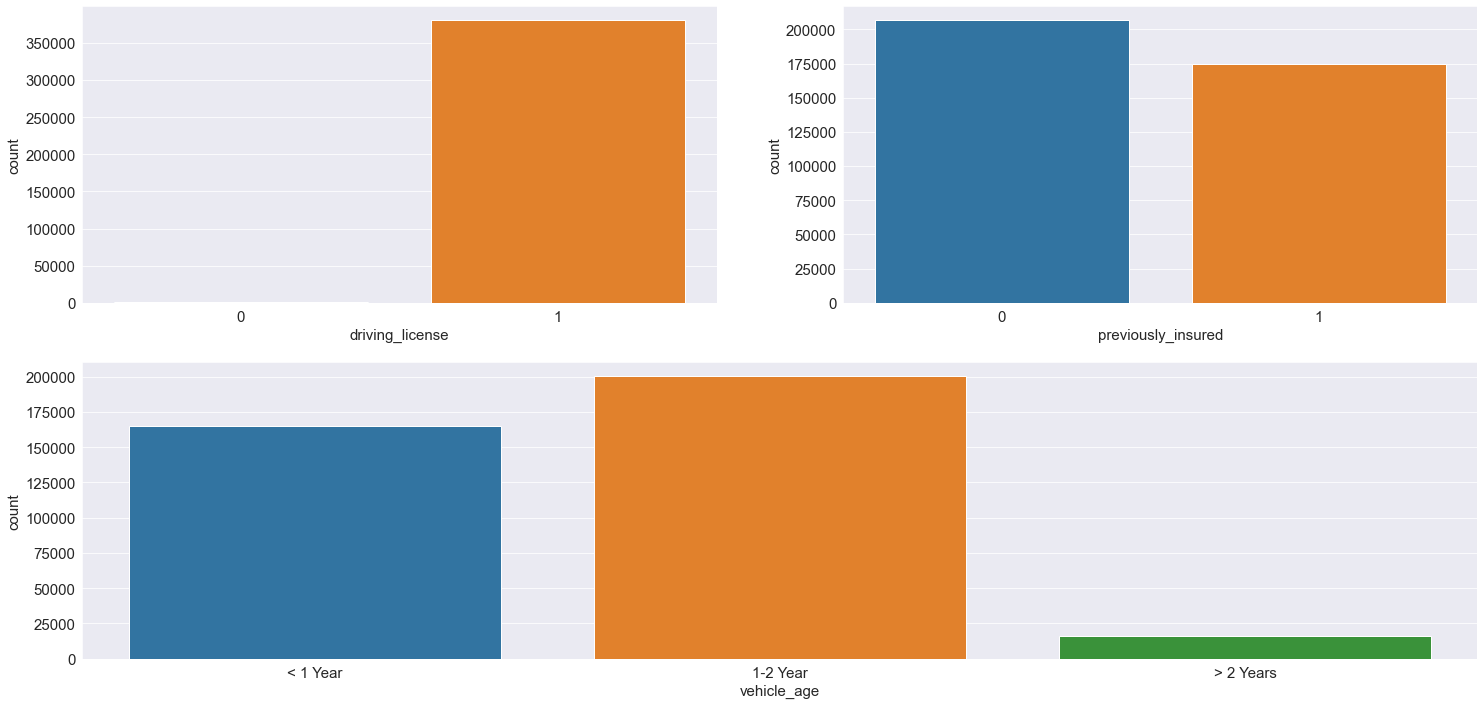

In [26]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(x='driving_license',data=data)

plt.subplot(grid[0,1])
sns.countplot(x='previously_insured',data=data)

plt.subplot(grid[1,:])
sns.countplot(data['vehicle_age'],order=['< 1 Year','1-2 Year','> 2 Years'])

The "driving license" column is highly unbalanced towards customers who pursue a license, as can be seen on the upper left plot. 

On the upper right plot, it is possible to see a more balanced distribution on the "previously insured" column.

And last, on the bottom plot, the distribution of "vehicle age" shows that most of the customers pursue newer vehicles, between 0 and 2 years.

### 6.2 Bivariate Analysis

On this subsection, the hyphotesis created before are put into test, one by one. Let's head to them.

#### 6.2.1 Hyphotesis 1: Customers that own a vehicle should be interest in the Vehicle Insurance offer.

* False: Most of the customers that own a vehicle actually don't have interested in Vehicle Insurance.

To check this first hyphotesis, we simply plot the response variable filtered only to the customers who pursue a driving license, which is considered here as a proxy variable that indicates that a customer have a vehicle.

<AxesSubplot:xlabel='response', ylabel='count'>

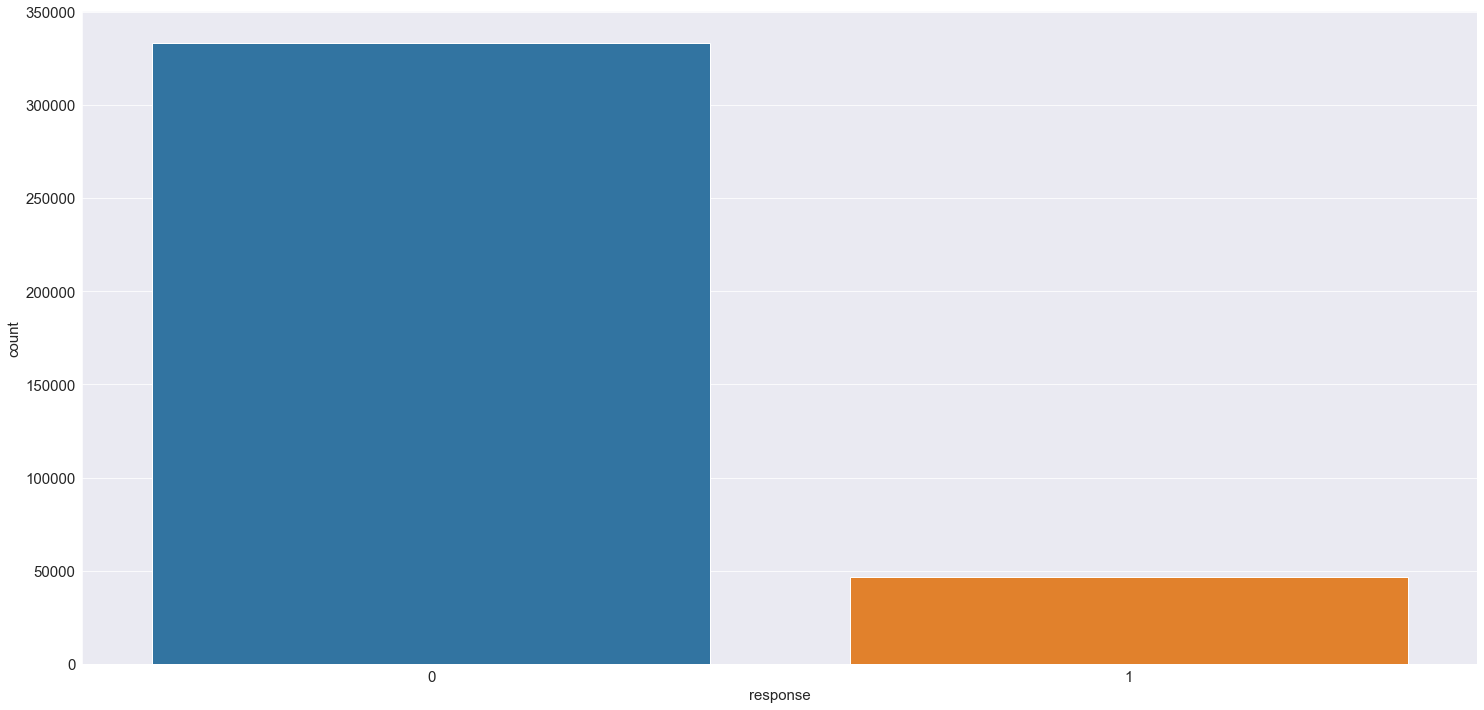

In [27]:
plot_data = data[data['driving_license']==1]
sns.countplot(x='response',data=plot_data)

Even on customers that have a vehicle, the number of people uninterested on the vehicle insurance offer is higher, making the hyphotesis false.

#### 6.2.2 Hyphotesis 2: Customers that had their vehicles damaged in the past should be interested in the Vehicle Insurance offer.

* False: Most of the customers that had their vehicles damaged in past actually don't have interested in Vehicle Insurance.

For this one, we again plot the response variable filtered for the customers who already have experienced a vehicle damage.

<AxesSubplot:xlabel='response', ylabel='count'>

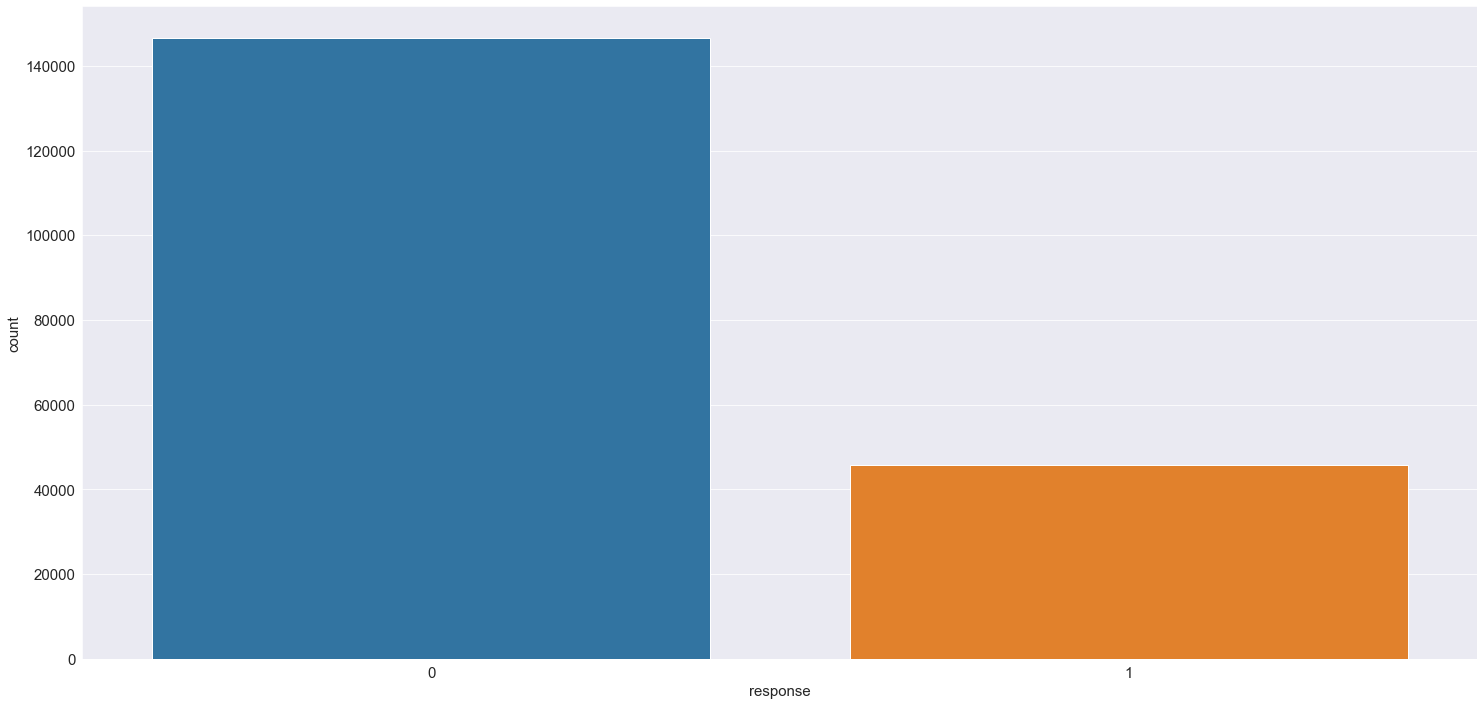

In [28]:
plot_data = data[data['vehicle_damage']=='Yes']
sns.countplot(x='response',data=plot_data)

And again, the marjority of customers don't have interest in the vehicle insurance, making the hyphotesis false.

#### 6.2.3 Hyphotesis 3: Customers with newer vehicles should be more interested in the Vehicle Insurance offer.

* False: Most of the customers that have interest in the Vehicle Insurance have vehicles with ages between 1 and 2 years.

For this hyphotesis, the response variable is again used, but this time, plotted for each period of "vehicle age".

<AxesSubplot:xlabel='vehicle_age', ylabel='gender'>

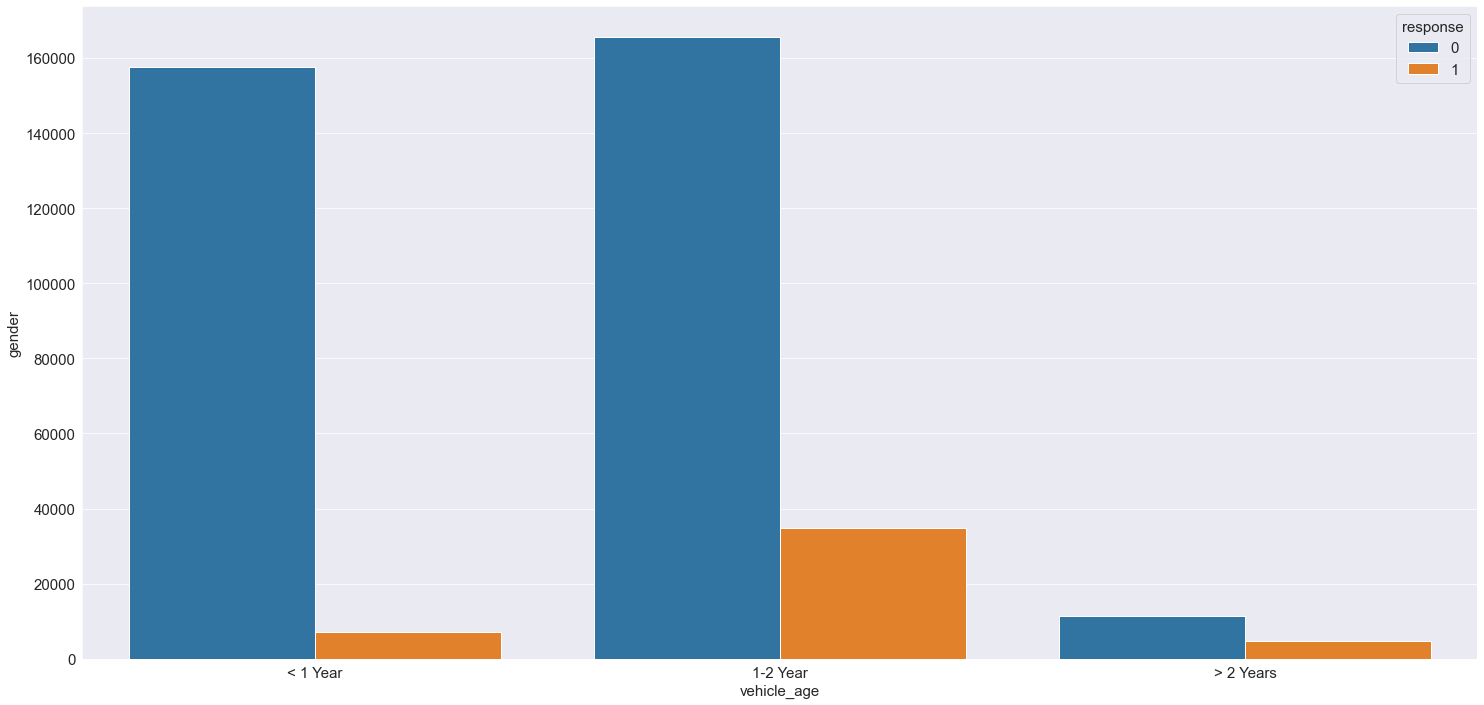

In [29]:
plot_data = data.groupby(['vehicle_age','response']).count().reset_index()
sns.barplot(x='vehicle_age',y='gender',data=plot_data,hue='response',order=['< 1 Year','1-2 Year','> 2 Years'])

And again, the uninterest is higher for all vehicles despite it's age, making the hyphotesis false.

#### 6.2.4 Hyphotesis 4: Older customers of the Health Insurance should be more interested in the Vehicle Insurance offer.
* False: The distribution of the interested and not interested customers remains almost constant between newer and older customers.

For the fourth hyphotesis, we can compare the plot of count of customers by vintage filtering by both the interested and non-interested customers on the vehicle insurance.

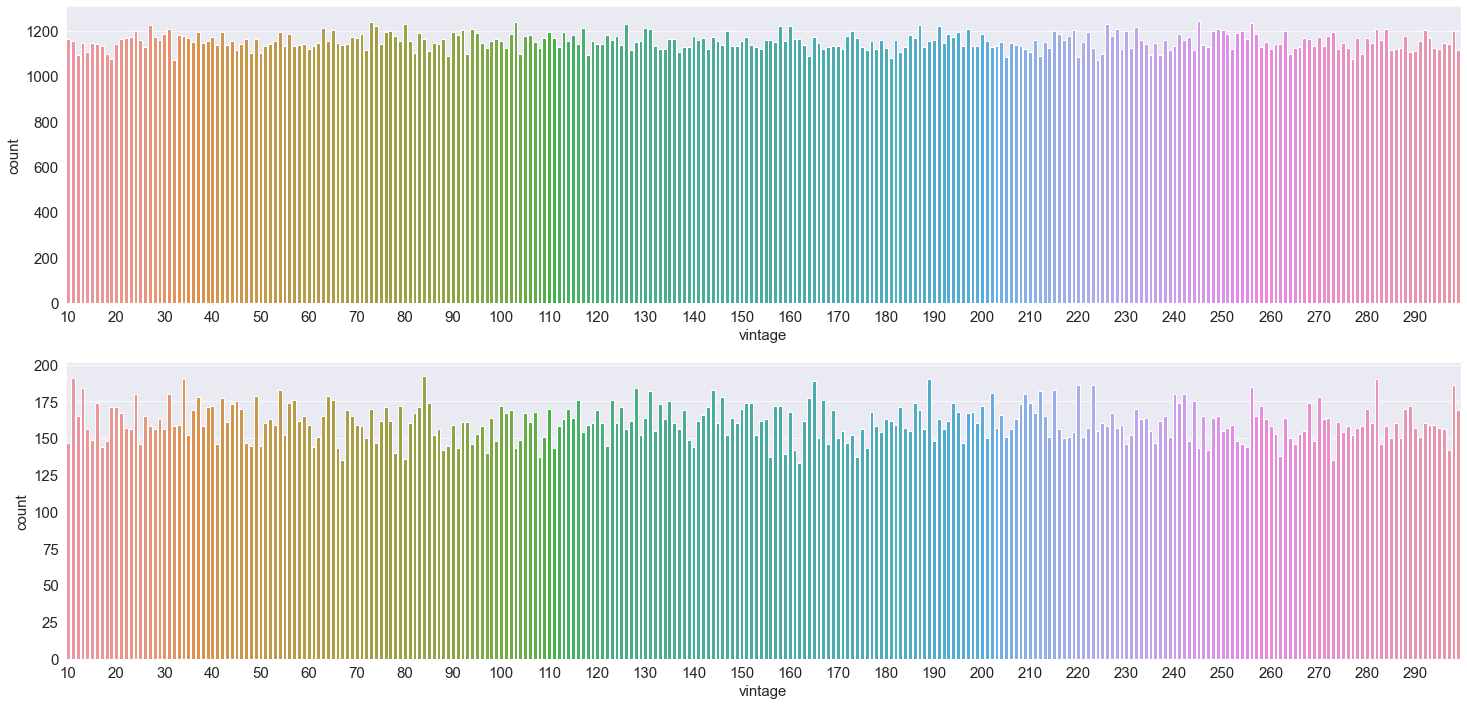

In [30]:
grid = plt.GridSpec(2,1)

plt.subplot(grid[0,0])
plot_data = data[data['response']==0]
ax = sns.countplot(x='vintage',data=plot_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.subplot(grid[1,0])
plot_data = data[data['response']==1]
ax = sns.countplot(x='vintage',data=plot_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

Both distributions behave almost constant, indicating no difference in interest between older and newer customers, making the hyphotesis false.

#### 6.2.5 Hyphotesis 5: Interest in Vehicle Insurance vary between different Regions.

* True: Different Regions have differences in customers interested in the vehicle insurance.

This hyphotesis can be checked by plotting the count of interested customers by region, as made below.

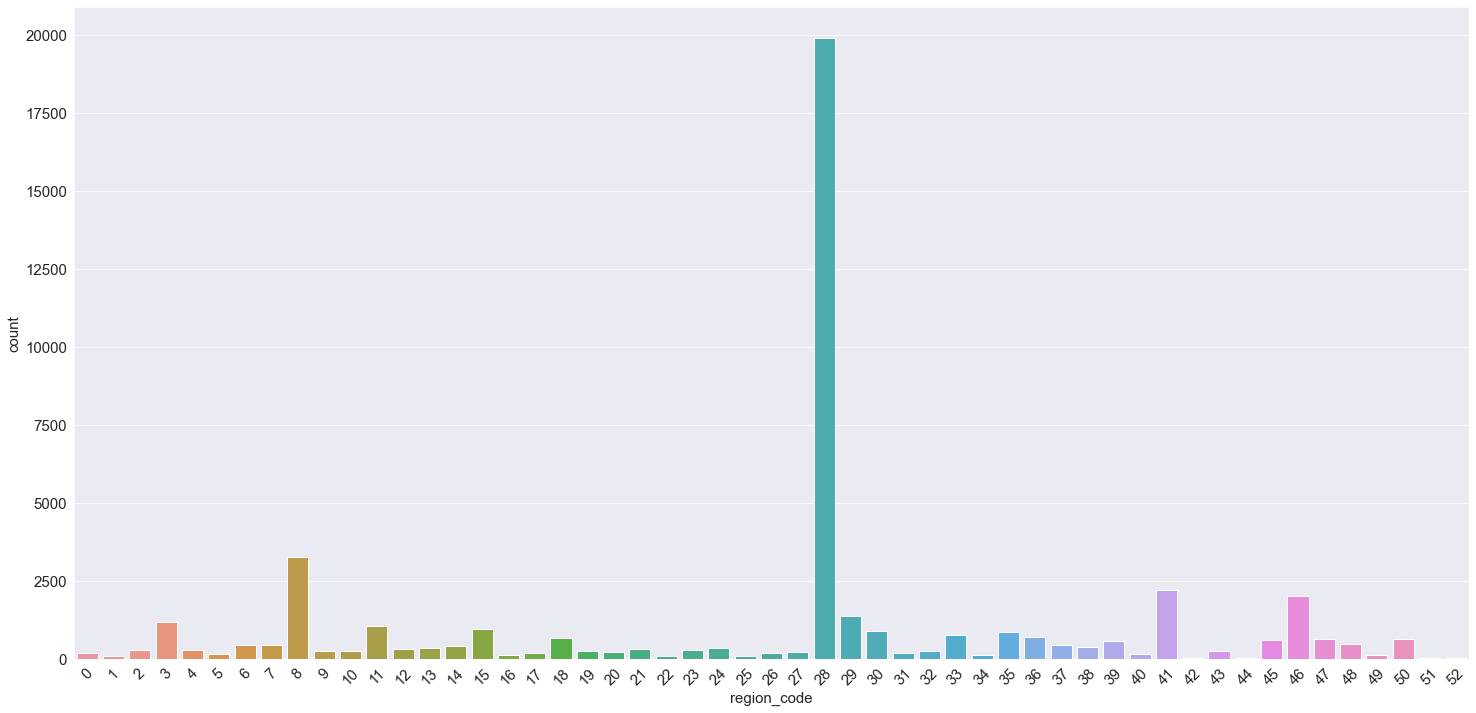

In [31]:
plot_data = data[data['response']==1]
sns.countplot(x='region_code',data=plot_data)
plt.xticks(rotation=45);

Definitely there's some variance of customers between regions, making the hyphotesis true.

#### 6.2.6 Hyphotesis 6: Customers with cheaper Premium prices should be more interest in the Vehicle Insurance offer.

* False: Both Customers interested and not interested in Vehicle Insurance follows a similar distribution in terms of the Premium Price.

For this last hyphotesis, we can plot the distribution of "annual premium" both for interested and uninterested customers and check any differences between them. Because of the presence of some outliers, a log scale is utilized.

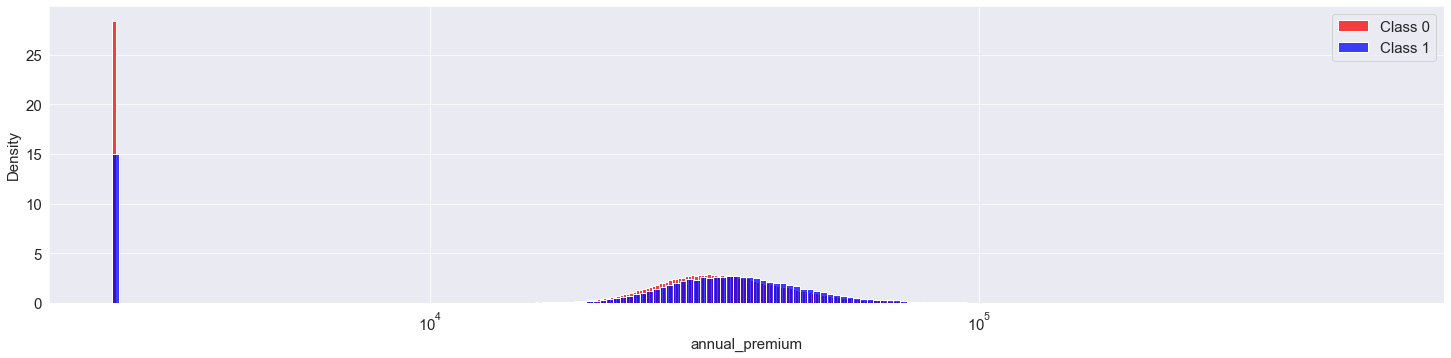

In [32]:
grid = plt.GridSpec(2,1)

plt.subplot(grid[0,0])
plot_data = data[data['response']==0]
ax = sns.histplot(x='annual_premium',data=plot_data,stat='density',color='red',label='Class 0',log_scale=True)

plot_data = data[data['response']==1]
sns.histplot(x='annual_premium',data=plot_data,ax=ax,stat='density',color='blue',label='Class 1',log_scale=True)
plt.legend()

As can be seen above, there's no significant difference between both distributions, making the hyphotesis false.

### 6.3 Multivariate Analysis

To finish this Exploratory Analysis, on this subsection a Multivariate Analysis is made, where more than two variables are involved. 

For both Numerical and Categorical Variables, a correlation plot is proposed.

#### 6.3.1 Numerical Variables

For the Numerical variables a heatmap with Pearson correlation is proposed.

<AxesSubplot:>

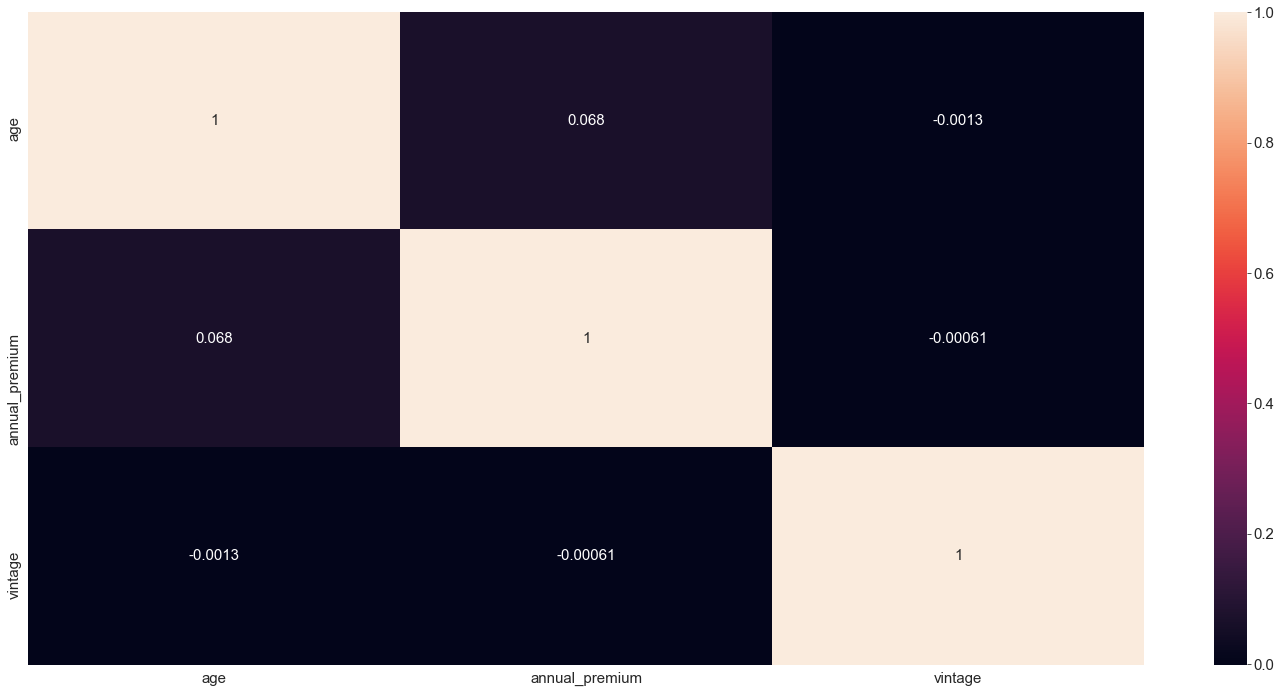

In [33]:
num_features = ['age','annual_premium','vintage']
correlation = data[num_features].corr(method = 'pearson')
sns.heatmap(correlation, annot=True)

In general, all the variables seem weakly correlated.

#### 6.3.2 Categorical Variables

For the Categorical variables, a Cramer-V heatmap is created below.

In [34]:
a1 = cramer_v(data['driving_license'],data['driving_license'])
a2 = cramer_v(data['driving_license'],data['previously_insured'])
a3 = cramer_v(data['driving_license'],data['vehicle_age'])

a4 = cramer_v(data['previously_insured'],data['driving_license'])
a5 = cramer_v(data['previously_insured'],data['previously_insured'])
a6 = cramer_v(data['previously_insured'],data['vehicle_age'])

a7 = cramer_v(data['vehicle_age'],data['driving_license'])
a8 = cramer_v(data['vehicle_age'],data['previously_insured'])
a9 = cramer_v(data['vehicle_age'],data['vehicle_age'])

In [35]:
correlation = pd.DataFrame({
    'driving_license' : [a1,a2,a3],
    'previously_insured' : [a4,a5,a6],
    'vehicle_age' : [a7,a8,a9]
})

correlation = correlation.set_index(correlation.columns)

<AxesSubplot:>

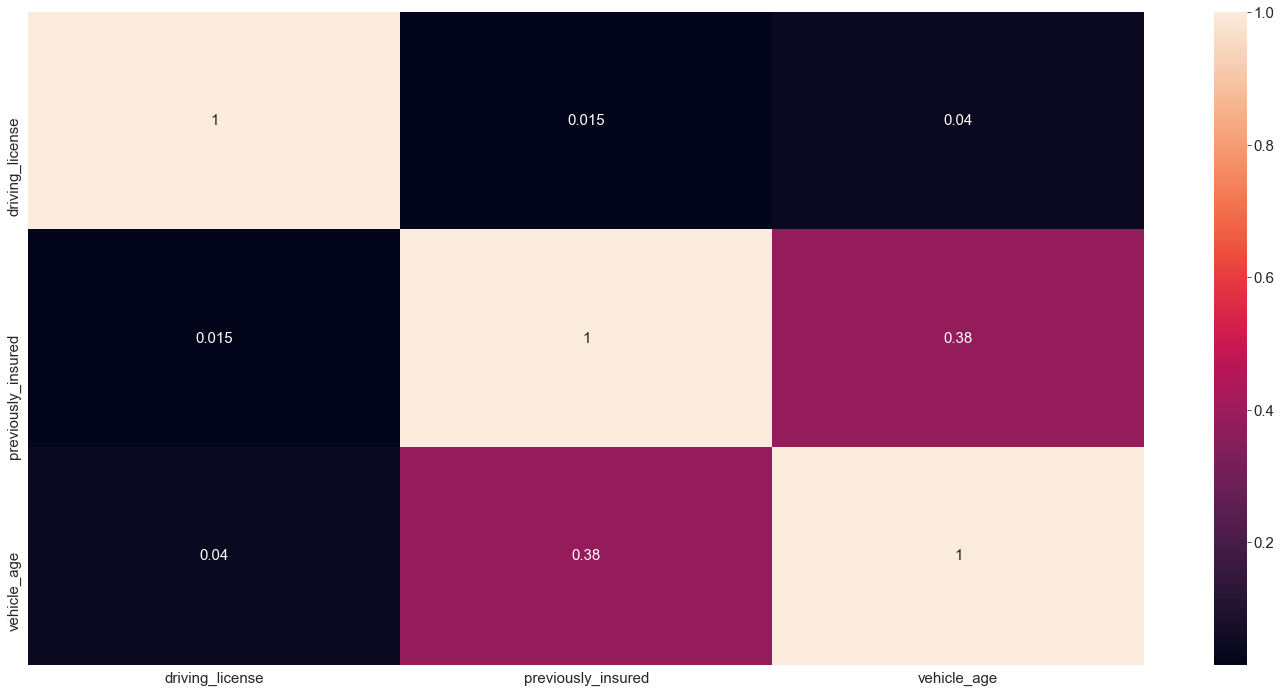

In [36]:
sns.heatmap(correlation,annot=True)

On the plot we can detect a at least siginificant correlation between the variables "Vehicle Age" and "Previously Insured".

## 7. Data Preparation

On this section, the origional dataset is submitted to some operations responsible for preparing it for the modelling step.

### 7.1 Transformations

We start off by making some transformations on columns. The main idea here is to make all the categorical columns be represented by numbers on the most appropriate way.

For the binary columns, "Gender" and "Vehicle Damage", the values are replaced by a 0-1 notation.

In [37]:
gender_dict = {'Male' : 0, 'Female' : 1}
data['gender'] = data['gender'].map(gender_dict)

In [38]:
vehicle_damage_dict = {'No' : 0, 'Yes' : 1}
data['vehicle_damage'] = data['vehicle_damage'].map(vehicle_damage_dict)

After that, the "Vehicle Age" column, which involves three categories, is converted to a One-Hot encoding.

In [39]:
data = pd.get_dummies(data,prefix=['vehicle_age'],columns=['vehicle_age'])

In [40]:
data.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,illegal_driver,no_insured_damage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
1,0,44,1,28,0,1,40454.0,26,217,1,0,1,0,0,1
2,0,76,1,3,0,0,33536.0,26,183,0,0,0,1,0,0
3,0,47,1,28,0,1,38294.0,26,27,1,0,1,0,0,1
4,0,21,1,11,1,0,28619.0,152,203,0,0,0,0,1,0
5,1,29,1,41,1,0,27496.0,152,39,0,0,0,0,1,0


### 7.2 Train-Test Split

Before continuing the preparation, a important step is proposed here: The separation of data between Train and Validation Set. Since ultil now we are working with the train set of a competition data, the "Test" set created here is called Validation to avoid any mistakes.

In [41]:
X = data.drop('response',axis=1)
y = data['response']

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)

### 7.3 Standardization

On this step, the Annual Premium columns is standardized.

In [43]:
ss = StandardScaler()

X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)
X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)
pickle.dump(ss,open('../Parameters/annual_premium_scaler.pkl','wb'))

### 7.4 Rescaling

On this subsection, the non-normal variables are rescaled, which involve the "Age" and "Vintage" variables.

In [44]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()


X_train['age'] = mms_age.fit_transform(X_train[['age']].values)
X_val['age'] = mms_age.transform(X_val[['age']].values)
pickle.dump(mms_age,open('../Parameters/age_scaler.pkl','wb'))

X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']].values)
pickle.dump(mms_vintage,open('../Parameters/vintage_scaler.pkl','wb'))

### 7.5 Encoding

Here, the more complex categorical variables are encoded. We start by applying a Target Encoding to "Region Code".

In [45]:
train_data = pd.concat([X_train,y_train],axis=1)

In [46]:
te_region_code = train_data.groupby('region_code')['response'].mean()
X_train['region_code'] = X_train['region_code'].map(te_region_code)
X_val['region_code'] = X_val['region_code'].map(te_region_code)
pickle.dump(te_region_code,open('../Parameters/region_code_encoder.pkl','wb'))

For, the "Policy Sales Channel" features, which has a high cardinality, we apply a Frequency Encoding.

In [47]:
te_policy_sales_channel = X_train.groupby('policy_sales_channel').size() / len(X_train)
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].map(te_policy_sales_channel)
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].map(te_policy_sales_channel)
pickle.dump(te_policy_sales_channel,open('../Parameters/policy_sales_channel_encoder.pkl','wb'))

### 7.6 Feature Selection

On this last subsection of Data Preparation, the Feature Selection process is applied, where only the variables most relevant to learning are maintained on the dataset. For this task, the Feature Importance score returned by the Random Forest model is used.

In [48]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [49]:
feature_importance = rf.feature_importances_

In [50]:
feature_importance = pd.DataFrame([X_train.columns,feature_importance]).T
feature_importance.columns = ['columns','feature_importance']
feature_importance = feature_importance.sort_values('feature_importance',ascending=False)

<AxesSubplot:xlabel='feature_importance', ylabel='columns'>

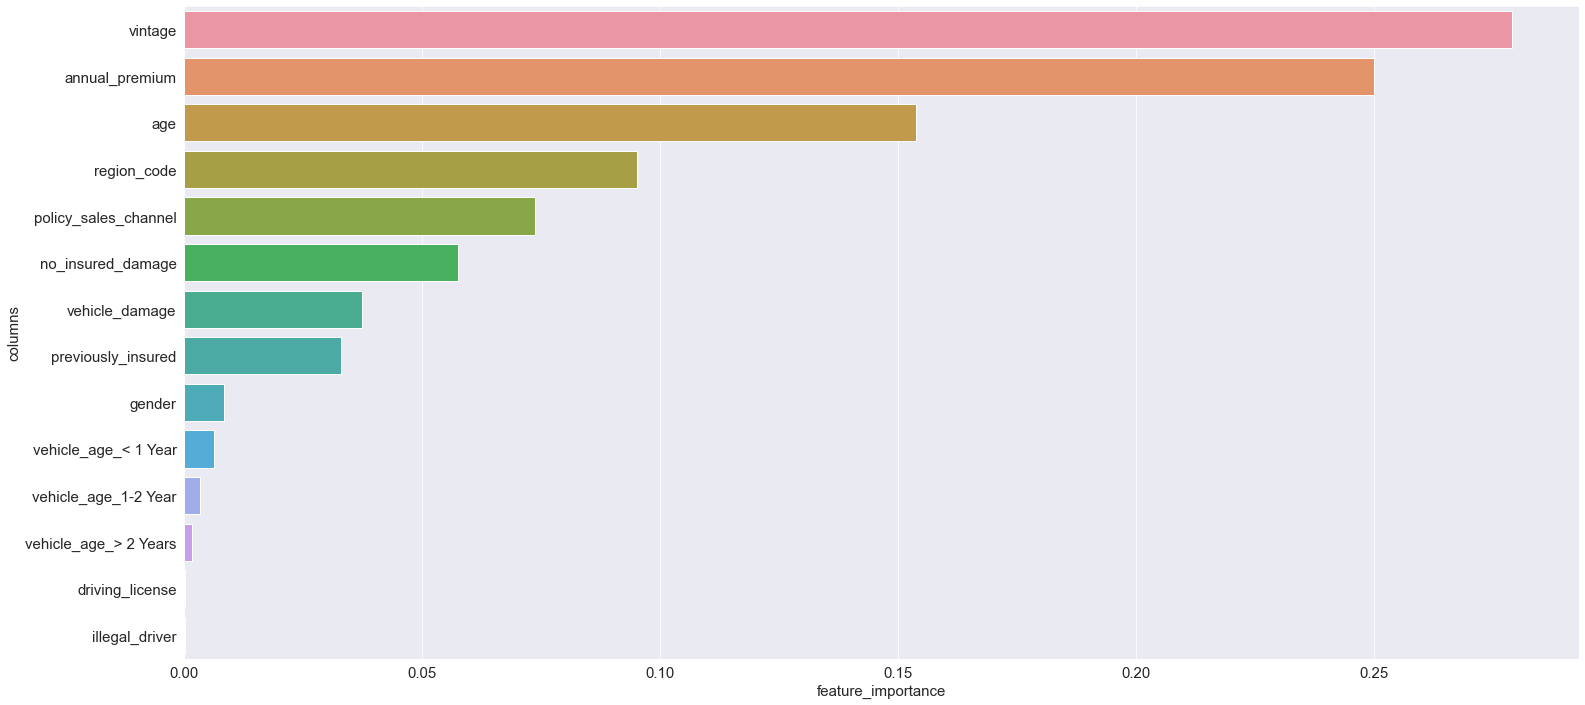

In [51]:
sns.barplot(y='columns',x='feature_importance',data=feature_importance,orient='h')

Based on the results obtained above, a manual definition of the selected features is proposed below.

In [52]:
selected_columns = ['vintage','annual_premium','age','region_code','policy_sales_channel','no_insured_damage','vehicle_damage','previously_insured']
X_train = X_train[selected_columns]
X_val = X_val[selected_columns]

In [53]:
X_train.head()

,vintage,annual_premium,age,region_code,policy_sales_channel,no_insured_damage,vehicle_damage,previously_insured
347089,0.740484,-0.070293,0.153846,0.126372,0.353411,0,0,1
148668,0.512111,-0.152861,0.061538,0.056488,0.353411,0,0,1
282683,0.408304,0.618745,0.630769,0.186677,0.209318,1,1,0
101296,0.889273,0.448502,0.030769,0.068651,0.353411,0,0,1
60279,0.916955,0.355199,0.046154,0.073176,0.353411,0,0,0


## 8. Modelling

On this section, the Machine Learning model to be used on the main problem of this work is defined. First, some different models are applied to data, and their performances are compared with the use of Precision and Recall metrics adapted to a Learn to Rank problem.

### 8.1 Logistic Regression

In [54]:
ls = LogisticRegression()
results_ls = cross_validation(model=ls,model_name='Logistic Regression',folds=5,k=20000,X=X_train,y=y_train)
results_ls

,Model,Precision at K (CV),Recall at K (CV)
0,Logistic Regression,0.269,0.859


### 8.2 kNN

In [55]:
knn = KNeighborsClassifier(n_neighbors=10)
results_knn = cross_validation(model=knn,model_name='kNN',folds=5,k=20000,X=X_train,y=y_train)
results_knn

,Model,Precision at K (CV),Recall at K (CV)
0,kNN,0.271,0.867


### 8.4 Random Forest

In [56]:
rf = RandomForestClassifier(n_estimators = 100,n_jobs=-1)
results_rf = cross_validation(model=rf,model_name='Random Forest',folds=5,k=20000,X=X_train,y=y_train)
results_rf

,Model,Precision at K (CV),Recall at K (CV)
0,Random Forest,0.28,0.895


### 8.5 XGBoost

In [57]:
xgboost =xgb.XGBClassifier(n_estimators = 100,tree_method='gpu_hist',objective='binary:logistic')
results_xgb = cross_validation(model=xgboost,model_name='XGBoost',folds=5,k=20000,X=X_train,y=y_train);
results_xgb

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost,0.284,0.908


### 8.6 Performance Comparison

On this subsection, the performance of the implemented models are compared.

In [58]:
comparison_performance = pd.concat([results_ls,results_knn,results_rf,results_xgb])
comparison_performance = comparison_performance.sort_values('Precision at K (CV)',ascending=False)
comparison_performance

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost,0.284,0.908
0,Random Forest,0.28,0.895
0,kNN,0.271,0.867
0,Logistic Regression,0.269,0.859


It is possible to see that the model with best performance is XGBoost. So, this will be our selected model for the rest of this work.

### 8.7 Hyperparameter Tuning

After the definiton of the model, to be used, on this subsection a process of tuning it's hyperparameters is proposed, with the goal to increase the model performance on this particular dataset. For maintaining the simplicity, a Random Search method is used for this task.

In [59]:
param = {
    'n_estimators' : [1000,1100,1200,1500,1700],
    'eta' : [0.01,0.03,0.05],
    'max_depth' : [2,3,4,5,7],
    'subsample' : [0.1,0.5,0.7],
    'colsample_bytree' : [0.3,0.7,0.9],
    'min_child_weight' : [3,8,15]
}

MAX_EVAL = 15

In [60]:
final_result = pd.DataFrame()

for size in range(MAX_EVAL):

    hp = {k : random.sample(v,1)[0] for k,v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBClassifier(
        n_estimators=hp['n_estimators'],
        eta=hp['eta'],
        max_depth=hp['max_depth'],
        subsample=hp['subsample'],
        colsample_bytree=hp['colsample_bytree'],
        min_child_weight=hp['min_child_weight'],
        tree_method = 'gpu_hist'
    )

    result = cross_validation(model=model_xgb,model_name='XGBoost',folds=5,k=20000,X=X_train,y=y_train);


    final_result = pd.concat([final_result, result])
final_result

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.05, 'max_depth': 7, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 2, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1100, 'eta': 0.01, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1000, 'eta': 0.05, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1200, 'eta': 0.01, 'max_depth': 7,

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost,0.285,0.91
0,XGBoost,0.283,0.905
0,XGBoost,0.284,0.906
0,XGBoost,0.283,0.906
0,XGBoost,0.284,0.908
0,XGBoost,0.284,0.909
0,XGBoost,0.285,0.91
0,XGBoost,0.285,0.911
0,XGBoost,0.285,0.911
0,XGBoost,0.285,0.911


### 8.8 Final Model

As a result of the last step, the hyperparameters below are selected for the final model.

In [61]:
param_tuned = {'n_estimators': 1200, 
                'eta': 0.01, 
                'max_depth': 7, 
                'subsample': 0.7, 
                'colsample_bytree': 0.7, 
                'min_child_weight': 3}

This model is them applied to data and it's predictions are generated.

In [62]:
X_train, y_train = balance_data(X_train, y_train)

In [63]:
model_xgb_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'],
    tree_method = 'gpu_hist').fit(X_train, y_train,eval_metric='auc')

yhat_xgb_tuned = model_xgb_tuned.predict_proba(X_val)

The model, and it's predictions are then saved for futher use.

In [64]:
pickle.dump(model_xgb_tuned, open('../Model/xgb_model.pkl','wb'))

In [65]:
model_predictions = pd.DataFrame(yhat_xgb_tuned,columns=['Class 0','Class 1'])
model_predictions.head()

,Class 0,Class 1
0,0.999003,0.000997
1,0.998196,0.001804
2,0.999576,0.000424
3,0.987717,0.012283
4,0.999484,0.000516


In [66]:
model_predictions.to_pickle('../Data/model_predictions.pkl')

## 9. Error Interpretation

### 9.1 Report for Business 

For reporting the model results to the Business teamns, managers and investors, on this section we use two very intuitive tools presented in the form of graphs: The Cumulative Gains Curve and the Lift Curve.

The first one, the Cumulative Gains Curve show us how much percentage of a determined class we can reach (Y-Axis) by using a specific percentage of the ordered scored list returned by the model (X-Axis). Also, on this curve, the graphs will also show a extra curve that presents the same concept of Cumulative Gains for a baseline random model. Basically, this tool can answer the question: How much interested clients we can reach by using just the first X % of the list returned by the model? And how better this is than selecting clients at random?

The Cumulative Gains Curve of our model can be seen below.

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

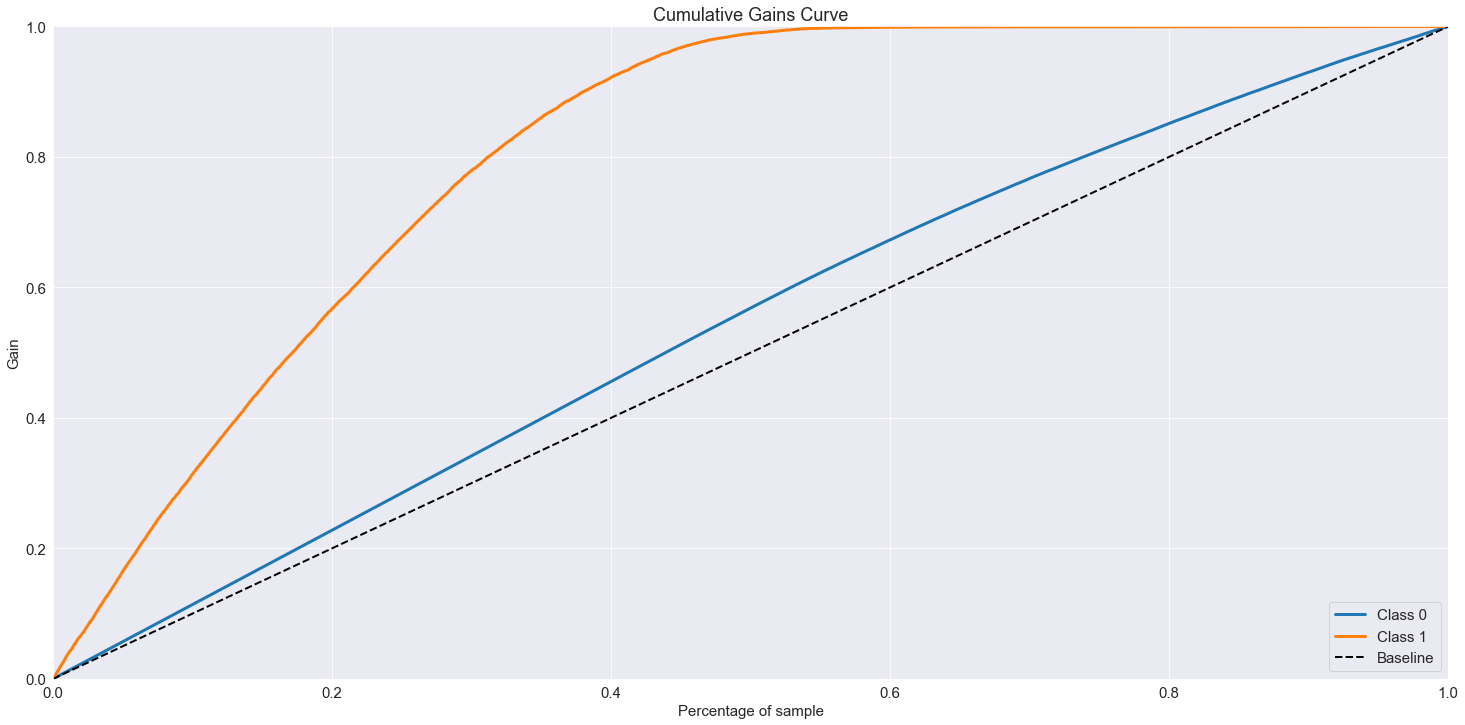

In [67]:
skplt.metrics.plot_cumulative_gain(y_val,model_predictions)

The second tool, the Lift Curve, is also a graphical tool that is similar to the Cumulative Gains Curve, but shows the results in terms of the ratio between the number of samples of the interested class reached and the total samples used from the model's list. So for example, if by using 30% of the list, it is possible to reach 60% of the interested customers, the Lift Curve presents a score of 2. Again, we can also compare the results with a random model which is presented as a flat curve with Score 1. So, basically this tool is a more objective way of answering how much better our model is compared to a random selection of customers.

The Lift Curve of our model can be seen below.

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

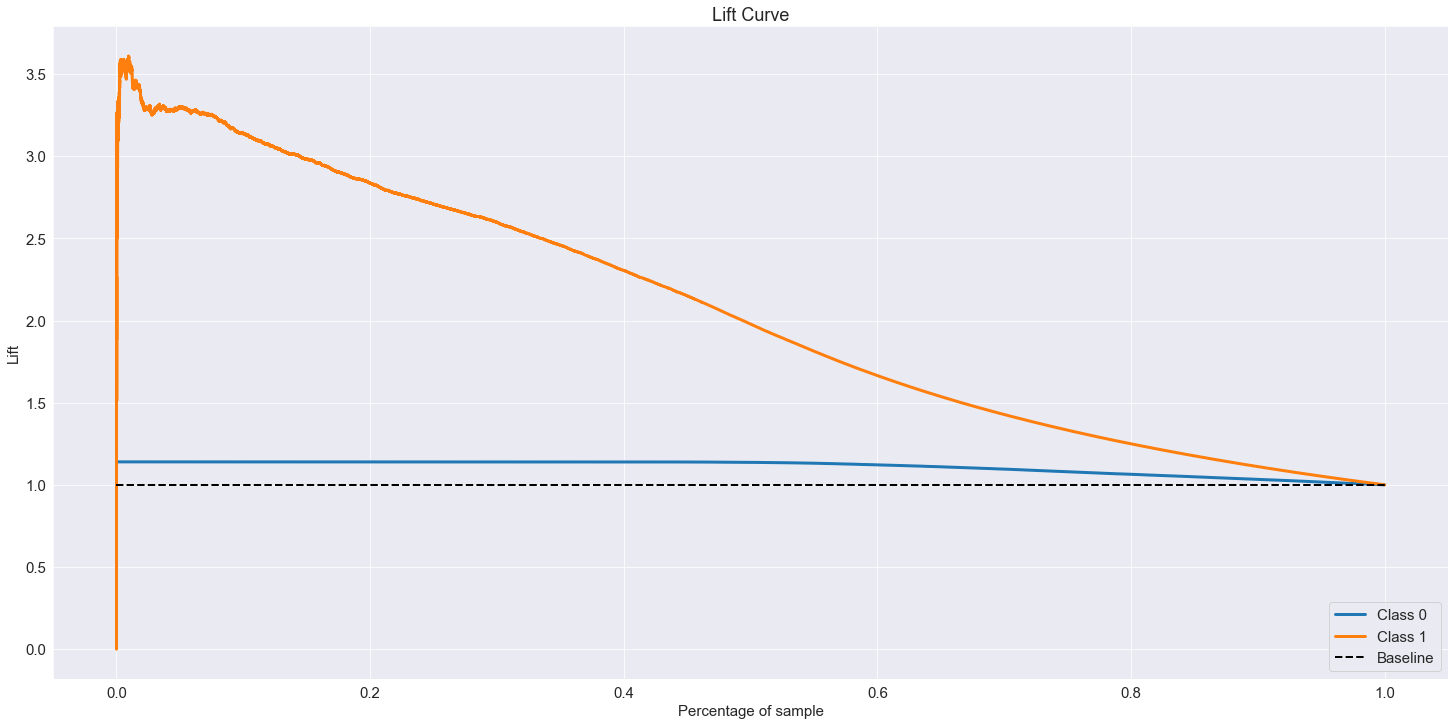

In [68]:
skplt.metrics.plot_lift_curve(y_val,model_predictions)

So, with this tools in mind, we can start answering some interesting questions to guide our analysis.

#### 1. How much percentage of interested clients can be contacted by calling the first 20000 clients of the list returned by the model?

Since the X-Axis on the graphs are presented as percentages, we first convert the 20000 value to a percentage of the list.

In [69]:
position_20000 = 20000/y_val.shape[0]

Now the Cumulative Gains Curve and the Lift Curve are again plotted, but now with a red vertical line indicating the 20000 position.

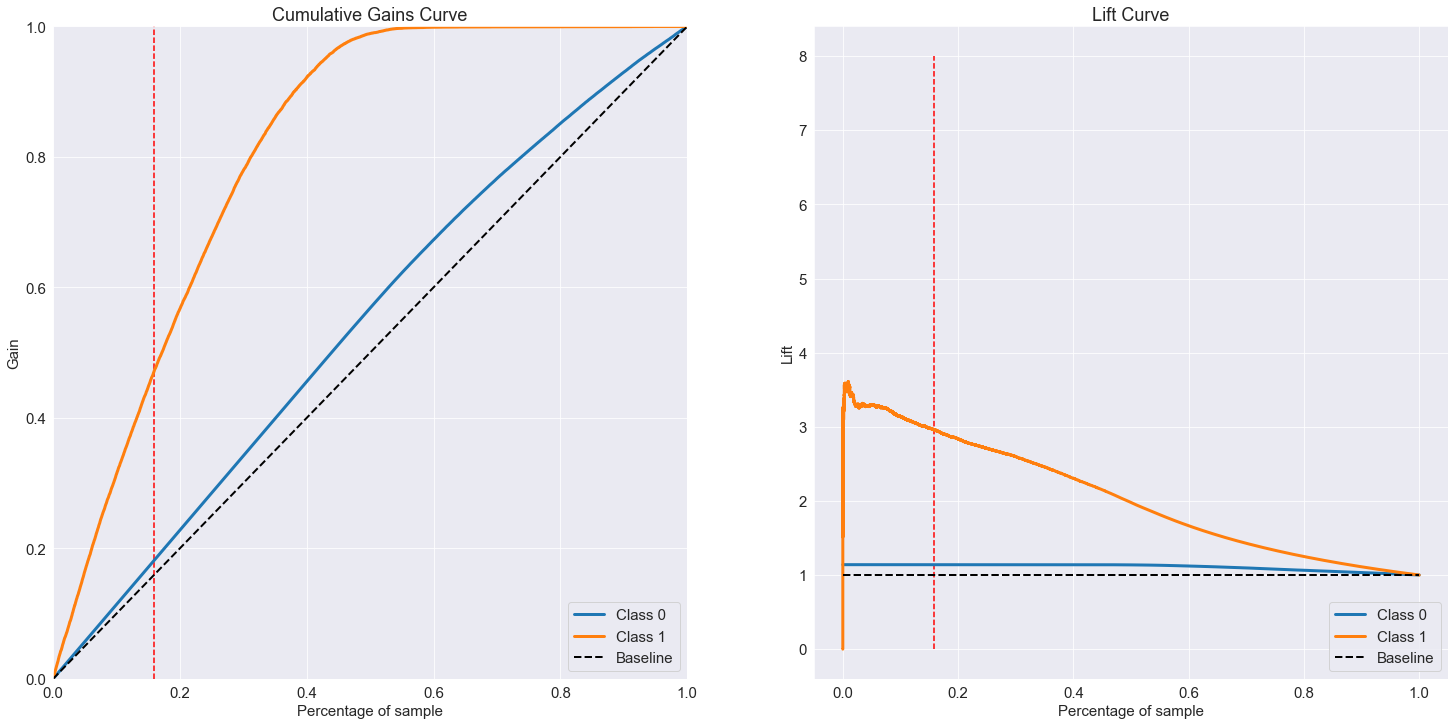

In [70]:
ax=plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_val,model_predictions,ax=ax)
plt.vlines(position_20000,0,1,'r','--')

ax = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_val,model_predictions,ax=ax)
plt.vlines(position_20000,0,8,'r','--')

In [71]:
precision, recall = calculate_performance(y_true=y_val, y_hat=yhat_xgb_tuned,k=20000)

results_tuned = generate_results_df('XGBoost Tuned', precision, recall)
results_tuned

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost Tuned,0.363,0.471


By calculating the recall at position 20000 on the list, we can conclude that making this amount of calls would make us reach 47.9% of the interested customers.

#### 2. And what about if we increase the number of calls to 40000? How much of the interested clients it is possible to reach?

The same process used on the first question is applied here, but considering now the 40000 value.

In [72]:
position_40000 = 40000/y_val.shape[0]

Now the Cumulative Gains Curve and the Lift Curve are again plotted, but now with a red vertical line indicating the 40000 position.

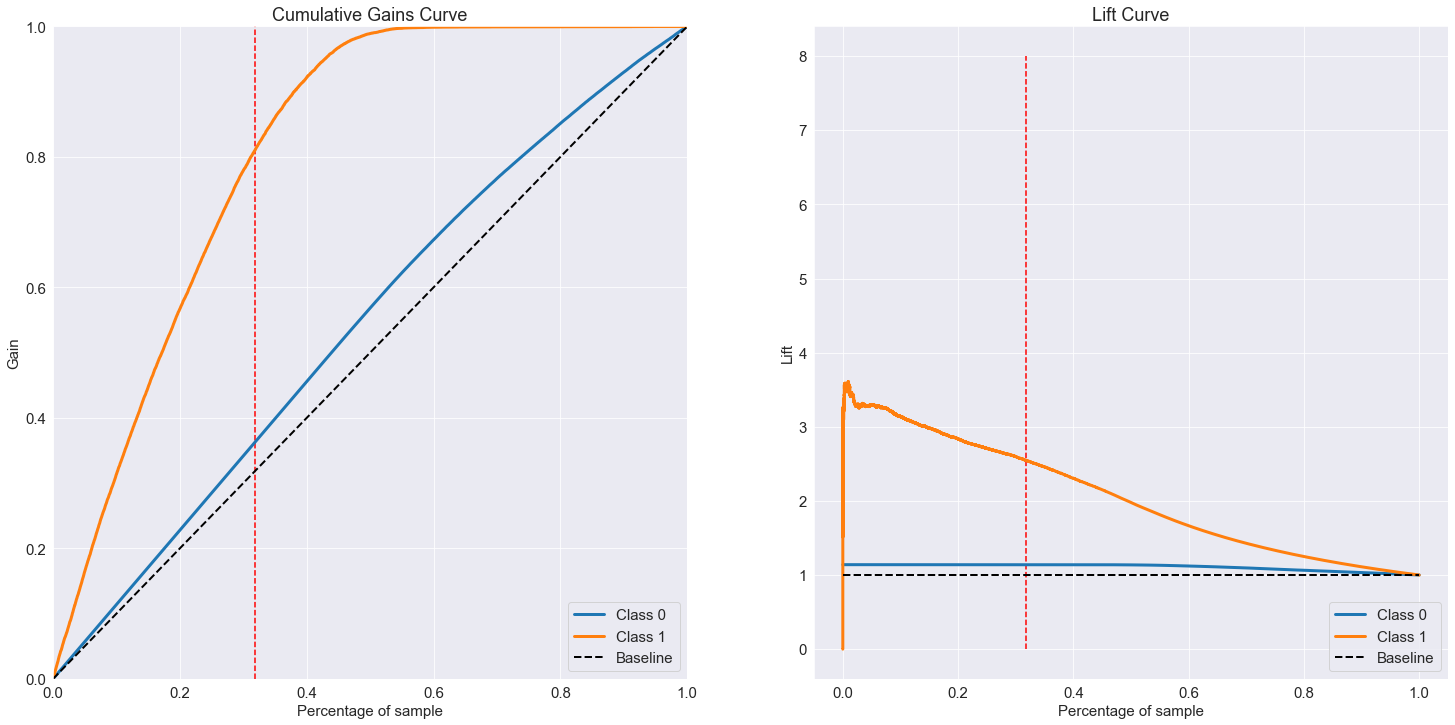

In [73]:
ax=plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_val,model_predictions,ax=ax)
plt.vlines(position_40000,0,1,'r','--')

ax = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_val,model_predictions,ax=ax)
plt.vlines(position_40000,0,8,'r','--')

In [74]:
precision, recall = calculate_performance(y_true=y_val, y_hat=yhat_xgb_tuned,k=40000)

results_tuned = generate_results_df('XGBoost Tuned', precision, recall)
results_tuned

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost Tuned,0.312,0.81


By calculating the Recall, we can conclude that incresing the number of calls to 40000, would make the Sales team reach 81.7% of the interested customers.

#### 3. How much calls the sales team needs to make to reach 80% of the interested clients?

To answer this last question, we can pot on the Cumulative Gains Curve a horizontal line on 80% of interested customers and check how much of the list needs to be evaluated.

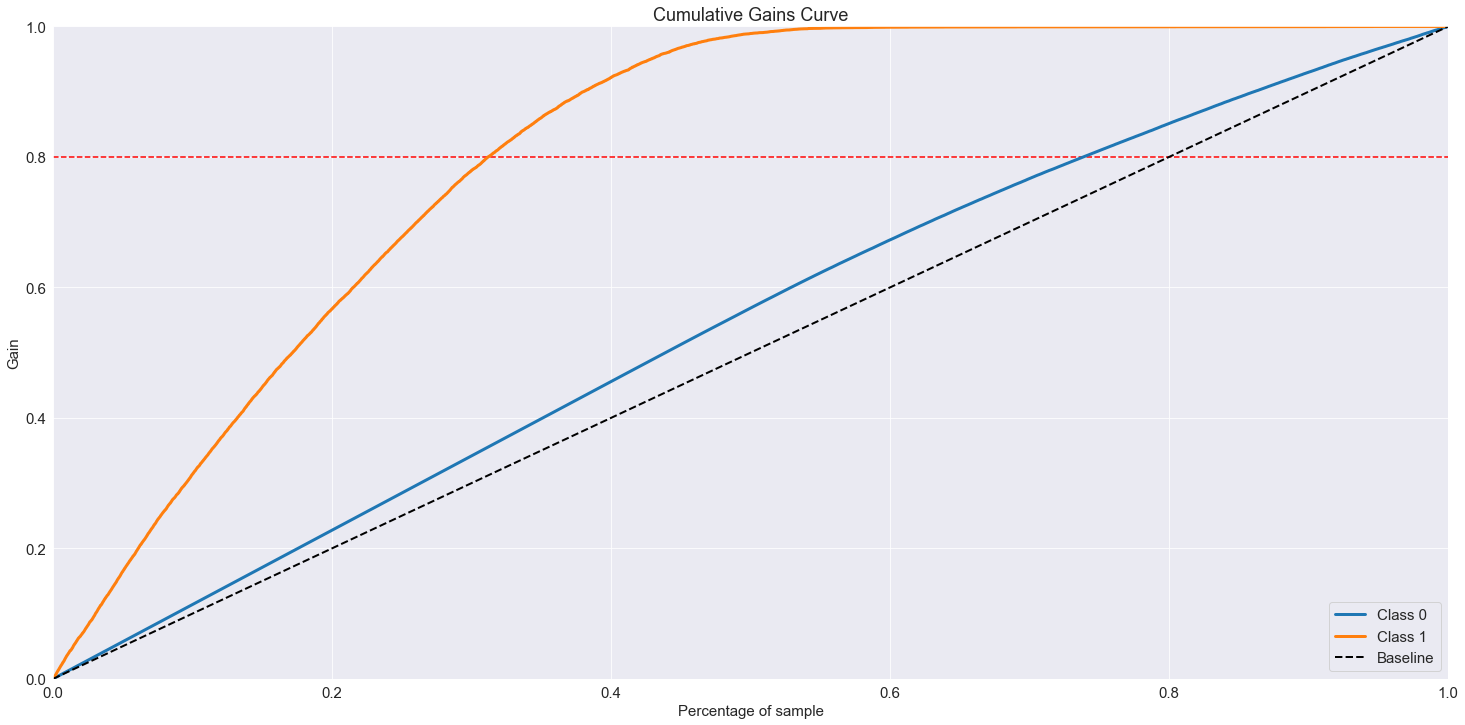

In [75]:
skplt.metrics.plot_cumulative_gain(y_val,model_predictions)
plt.hlines(0.8,0,1,'r','--')

It seems that approximately 30% of the list is needed to achieve that.

### 9.2 Report for Data Scientists

On this section, a more technical report of the results is proposed, aiming Data Scientists and Analysts. The main idea here is to understand the model's performance in terms of the error metrics used on the Cross-Validation and to select the hyperparameters.
As can be seen, two metrics were used, despite only one is truly being considered. The first one, Precision at K, consists of calculating the Precision of the model for the first K samples of the ordered list. Mathematically, this metric can be given by:

$$Precision \: at \: K = \frac{True \: Positives \: at \: K}{(True \: Positives \: at \: K) + (False \: Positives \: at \: K)} = \frac{Number \: of  \: Interested \: Customers \: correctly \: predicted \: by  \: the \: Model \: at \: K }{Number \: of \: all \: Customers \: predicted  \: as \: Interested \: at \: K}$$

In technical terms, the Precision measures how much of the positive predictions of the model are really correct. On the right side of equation, this sentence is translated to our problem: How much of the Customers that the model recommended are really interested on the Vehicle Insurance offer?

Recall is a very close metric to Precision, but it has a different meaning. Mathematically:

$$Recall \: at \: K = \frac{True \: Positives \: at \: K}{(True \: Positives \: at \: K) + (False \: Negatives \: at \: K)} = \frac{Number \: of  \: Interested \: Customers \: correctly \: predicted \: by  \: the \: Model \: at \: K }{Number \: of \: all \: Interested \: Customers \: at \: K}$$

This metric actually measure how much of the true positive samples are predicted as positives by the model. In terms of the problem: How much of the truly interested customers are correctly predicted by the model?

The difference is subtle but briefly, Precision is based on the total of POSITIVE PREDICTIONS of the model, and Recall is based on the total of POSITIVE SAMPLES of the data.

So, after understaing that, what does these metrics tell us about the models? Let's check again the results obtained on the Model Comparison.

In [76]:
comparison_performance

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost,0.284,0.908
0,Random Forest,0.28,0.895
0,kNN,0.271,0.867
0,Logistic Regression,0.269,0.859


In general, it is possible to see that all the models reached a High Recall but with Lower Precisions. What that means, is that in terms of correctly predicting the Truly Interested Clients, the model presents a good performance, but to reach that, a lot of predicitions of potential clients are made, and a lot of them are incorrect. These errors of the model is an important observation, and can be a probably consequence of the disbalance of the data between interested and uninterested customers. 

After these discussions, we can finish this section by analyzing the actual results of the model on validation data. Let's check that.

In [77]:
precision, recall = calculate_performance(y_true=y_val, y_hat=yhat_xgb_tuned,k=20000)

results_tuned = generate_results_df('XGBoost Tuned', precision, recall)
results_tuned

,Model,Precision at K (CV),Recall at K (CV)
0,XGBoost Tuned,0.363,0.471


The result presented the same pattern of high recall-low precision, but overall, we can see a high decrease in the performance of the model on the validation data compared to the training performance, which can be a possible result of overfitting. This result can be a good opportunity for improvement in the future.